In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import balance

In [2]:
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')
table = tables[14]
key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# __I\O - таблицы__

Пусть экономика состоит из $n$ промышленных отраслей, производящие __вторичные ресурсы__ и потребляющая $m$ видов __первичных ресурсов__, так же пусть имеется $l$ __конечных потребителей__, потребляющие вторичные ресурсы. Тогда можно ввести __I/O__-таблицу $\hat{Z}$ размера $(n+m)\times(n+l)$, в ячейках которой записаны потоки товаров из одной отрасли в другую.

Одним из примеров баз данных можно привести $NIOT$, разделяющую экономику на $n=56$ отраслей и $l = 6$ конечных потребителя. Так же в этих таблицах можно выделить $m=3$ первичных ресурса. Так как статистика потребления первичных ресурсов конечными потребителями в некотором смысле плохая, будем считать, что конечные потребители не потребляют первичные рессурсы.

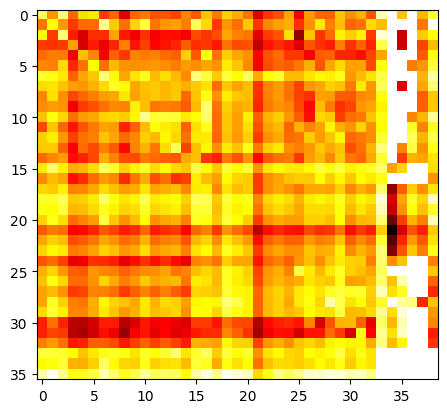

In [3]:
plt.imshow(jnp.log(table), cmap='hot', interpolation='nearest')
plt.show()

# __Производственные Функции__

Рассмотрим модель экономики, называемой __Межотраслевым Балансом__. Неформально ее можно описать как набор производственных функций и потребителей, которые закупаясь по некоторым рыночным ценам и максимизируя полезность\доход воспроизводят(приближенно) __I/O__-таблицы.   Допустимых функций бесконечно много - вопрос в том как такие найти. Хорошим классом является CES. Для любой корректной $\hat{Z}$ и люого $\rho\in\mathbb{R}^{n}_{++}$ существуют веса $W$, что в равновесных ценах пропорции воспроизведутся. Стартанем отсюда.

In [4]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
Z0_hat = jnp.sum(table[:,n:], axis = 1)
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)

Имея на руках производственные функции можно найти равновесные цены, полагая $s$ зафиксированным(и единичным).

In [5]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)

Имея равновесные цены $p$ можно рассчитать и пропорции потребления. Важно заметить, что это именно пропорции, а не точное воспроизведение.
В дальнейшем мы будем так же и масштабировать, чтоб получить функцию ошибки, и ее дифференциировать. Как видно они похожи, но не 1 в 1
(а разве не должны быть 1 в 1?)

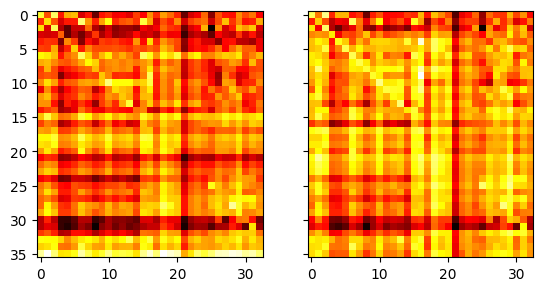

In [6]:
Z = balance.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(Z), cmap='hot', interpolation='nearest')

In [7]:
jnp.sum(jnp.abs(Z_hat - Z))/jnp.sum(Z_hat)

Array(0.9999932, dtype=float32)

Подгоним масштабирующие коэффициенты так, чтоб из пропорций потребления получились наиболее приближенными к данным. При этом очень важно учесть, что так же должен существовать и вектор конечного потребления, чтоб воспроизводилась корректная __I/O__-таблица. Поиск такий масштабирующих коэффициентов можно записать как задачу линейного программирования.(Решать LP оказалось ну очень накладно, нужно воспользоваться методом науча)

In [8]:
J1, x, u = balance.primal_J(Z, Z_hat)
J1

3282078.6304780333

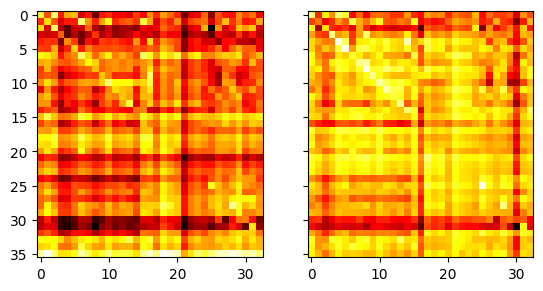

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

In [10]:
jnp.sum(jnp.abs(Z_hat - x * Z))/jnp.sum(Z_hat)
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)


Да чет ну совсем не похоже, оно объясняет только 3% от потребления. Попытаемся подогнать из соображений воспроизведения конечного спроса. Работает оно лучше, но как взять градиент пока без идей. 

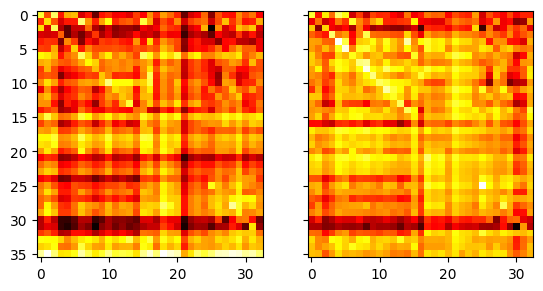

In [11]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
Z0_hat = jnp.sum(table[:n,n:], axis = 1)
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)
Z = balance.JCES(p, W, rho)
y = jnp.linalg.inv(jnp.diag(jnp.sum(Z, axis = 0)) - Z[:n,:]) @ Z0_hat  # по-факту это решение задачи оптимизации. 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(Z * y), cmap='hot', interpolation='nearest')

In [12]:
jnp.sum(jnp.abs(Z_hat - Z * y))/jnp.sum(Z_hat), jnp.sum(jnp.abs(Z_hat - 0.01 * Z * y))/jnp.sum(Z_hat)

(Array(7.8811603, dtype=float32), Array(0.97367936, dtype=float32))

Вообще не сходится, хотя визуально похоже. Все работает явно быстрее, но в целом не работает. По-хорошему нужно перековыряться в balance.get_W и только потом продолжать разработку. 

Но по-хорошему оно должно в точности воспроизводить потребление $\hat{Z}$, а не приближенно. Более чем уверен, что ошибка в balance.get_W, но вроде все правильно. Поговорю на этот счет с научем. Во всем остальном уверен. Нужно посчитать $\nabla_{Z} J$ и попытаться _выучить_ пропорции $\hat{Z}$. Тогда можно будет раскручитвать подход дальше.

In [13]:
J2, nu, lam = balance.dual_J(Z, Z_hat)
J1, J2

(3282078.6304780333, 3282078.6258366248)

In [14]:
(J1 - J2)/J1

1.4141673887043616e-09

In [15]:
balance.grad_J(Z, Z_hat)

error= 0.9707192


Array([[-13522.661  ,  -2268.9941 ,  -1080.3696 , ...,   -931.90564,
         -7651.0483 , -59770.402  ],
       [ -5643.792  ,  -1433.675  ,   -450.901  , ...,   -477.745  ,
         -3193.227  , -42632.273  ],
       [-13522.661  ,  -2268.9941 ,  -1080.3696 , ...,   -931.90564,
         -7651.0483 , -59770.402  ],
       ...,
       [-13522.661  ,  -2268.9941 ,  -1080.3696 , ...,   -931.90564,
         -7651.0483 , -59770.402  ],
       [-13522.661  ,  -2268.9941 ,  -1080.3696 , ...,   -931.90564,
         -7651.0483 , -59770.402  ],
       [-13522.661  ,  -2268.9941 ,  -1080.3696 , ...,   -931.90564,
         -7651.0483 , -59770.402  ]], dtype=float32)

Попытаемся через градиентный спуск выучить пропорции. Зафиксируем случайный стартовый $Z$ и градиентным спуском минимизировать $J$. По-хорошему нужно провести анализ, чтоб определить параметры, может быть взять что-то универсальное. Но пока так.

In [16]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
Z =  jax.random.uniform(key,(n+m, n))
for k in range(1):
    print(k)
    grad = balance.grad_J(Z, Z_hat)
    Z -= 1000 * grad
    Z = jnp.maximum(Z, jnp.zeros((n+m,n)))

0
error= 0.96079475


0.8292119


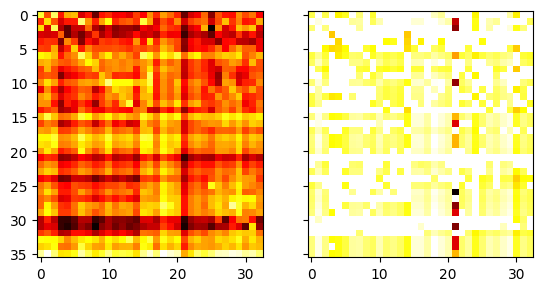

In [17]:
J, x, u = balance.primal_J(Z,Z_hat)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
print(J/jnp.sum(Z_hat))
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

In [18]:
balance.grad_J(Z, Z_hat)

error= 0.8292119


Array([[-0.00209605, -0.00438424, -0.00227262, ...,  0.00086231,
        -0.00258958, -0.00118967],
       [-0.00209605, -0.00075568, -0.00227262, ..., -0.00086231,
        -0.00258958, -0.00118967],
       [-0.00209605, -0.00438424, -0.00227262, ..., -0.00086231,
        -0.00258958, -0.00118967],
       ...,
       [-0.00209605, -0.00438424, -0.00227262, ..., -0.00086231,
        -0.00258958, -0.00118967],
       [-0.00209605, -0.00438424, -0.00227262, ..., -0.00086231,
        -0.00258958, -0.00118967],
       [-0.00209605, -0.00438424, -0.00227262, ..., -0.00086231,
        -0.00258958, -0.00118967]], dtype=float32)

Кажись сама задача по подгону $Z$ невыпуклая ну совсем, быстро находится локальный минимум, сильно далекий от оптимума.
Осталось надеятся, что предсказанные пропорции сразу попадут в один бассейн с оптимумом.

__Проверим как оно ДООБУЧИТ предсказанные пропорции__

In [19]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)

In [20]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)

In [21]:
Z = balance.JCES(p, W, rho)
for k in range(1):
    print(k)
    grad = balance.grad_J(Z, Z_hat)
    Z -= grad
    Z = jnp.maximum(Z, jnp.zeros((n+m,n)))

0
error= 0.9707192


0.91478395


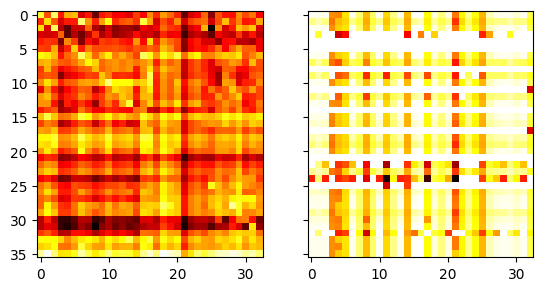

In [22]:
J, x, u = balance.primal_J(Z,Z_hat)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
print(J/jnp.sum(Z_hat))
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

И близко нет, видимо придется делать штуку с воспроизведением по вектору потребления. Все эти игры с  "отковыриванием" вектора потребления были ошибкой.
Нужно откатить изменения для генерации $W$ и переписать ошибку $J$ чтоб оно приближало лучшим способом при условии воспроизведения вектора потребления. Видимо он должен тоже быть __на входе__ вместе с __ценами на первичные ресурсы__.